In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import r2_score

# 1. Data Inspection

In [2]:
bike = pd.DataFrame(pd.read_csv("data/london_merged.csv"))
bike.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [3]:
# "timestamp" - timestamp field for grouping the data
# "cnt" - the count of a new bike shares
# "t1" - real temperature in C
# "t2" - temperature in C "feels like"
# "hum" - humidity in percentage
# "wind_speed" - wind speed in km/h
# "weather_code" - category of the weather
# "is_holiday" - boolean field - 1 holiday / 0 non holiday
# "is_weekend" - boolean field - 1 if the day is weekend
# "season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

# "weathe_code" category description:
# 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 2 = scattered clouds / few clouds 3 = Broken clouds 4 = Cloudy 7 = Rain/ light Rain shower/ Light rain 10 = rain with thunderstorm 26 = snowfall 94 = Freezing Fog

In [4]:
bike.info()
print(bike.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB
(17414, 10)


In [5]:
bike.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


In [6]:
round(100*(bike.isnull().sum()/len(bike)), 2).sort_values(ascending=False)
round((bike.isnull().sum(axis=1)/len(bike))*100,2).sort_values(ascending=False)

0        0.0
11607    0.0
11613    0.0
11612    0.0
11611    0.0
        ... 
5810     0.0
5811     0.0
5812     0.0
5813     0.0
17413    0.0
Length: 17414, dtype: float64

# 2. Data Cleaning

In [7]:
rawData=bike.copy()
for col in rawData:
    print(rawData[col].value_counts(ascending=False), '\n\n')

timestamp
2015-01-04 00:00:00    1
2016-05-04 12:00:00    1
2016-05-04 18:00:00    1
2016-05-04 17:00:00    1
2016-05-04 16:00:00    1
                      ..
2015-09-03 17:00:00    1
2015-09-03 18:00:00    1
2015-09-03 19:00:00    1
2015-09-03 20:00:00    1
2017-01-03 23:00:00    1
Name: count, Length: 17414, dtype: int64 


cnt
46      46
53      39
33      36
70      36
120     36
        ..
3022     1
3112     1
1338     1
3270     1
2220     1
Name: count, Length: 3781, dtype: int64 


t1
 13.000000    969
 12.000000    822
 9.000000     807
 14.000000    802
 11.000000    779
             ... 
 31.500000      3
 31.000000      3
 34.000000      2
-1.500000       1
 10.333333      1
Name: count, Length: 73, dtype: int64 


t2
 13.000000    969
 12.000000    821
 14.000000    802
 11.000000    774
 16.000000    729
             ... 
 33.000000      2
-5.500000       1
-5.000000       1
-6.000000       1
 10.333333      1
Name: count, Length: 82, dtype: int64 


hum
88.00    965
82

In [8]:
bike['timestamp'] = pd.to_datetime(bike['timestamp'])
bike = bike[bike['timestamp'].dt.year != 2017]

bike['year'] = bike['timestamp'].dt.year
bike['month'] = bike['timestamp'].dt.month
bike['weekday'] = bike['timestamp'].dt.dayofweek + 1

In [9]:
# 1.Early: -7am
# 2.AM peak: 7am-10am
# 3.Midday: 10am-4pm
# 4.PM Peak: 4pm-7pm
# 5.Evening: 7pm-10pm
# 6.Late: 10pm+


def get_time_period(timestamp):
    hour = timestamp.hour
    if hour < 7:
        return 1
    elif hour < 10:
        return 2
    elif hour < 16:
        return 3
    elif hour < 19:
        return 4
    elif hour < 22:
        return 5
    else:
        return 6
bike['time_period'] = bike['timestamp'].apply(get_time_period)

In [10]:
bike.drop(columns='timestamp',inplace=True)
bike.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,weekday,time_period
0,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,1,7,1
1,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,1,7,1
2,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015,1,7,1
3,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015,1,7,1
4,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015,1,7,1


In [11]:
bike['weather_code']=bike['weather_code'].astype('category')
bike['season']=bike['season'].astype('category')
bike['year']=bike['year'].astype('category')
bike['month']=bike['month'].astype('category')
bike['weekday']=bike['weekday'].astype('category')
bike['time_period']=bike['time_period'].astype('category')

bike_new = pd.get_dummies(bike, drop_first=True)
bike_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17342 entries, 0 to 17341
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cnt                17342 non-null  int64  
 1   t1                 17342 non-null  float64
 2   t2                 17342 non-null  float64
 3   hum                17342 non-null  float64
 4   wind_speed         17342 non-null  float64
 5   is_holiday         17342 non-null  float64
 6   is_weekend         17342 non-null  float64
 7   weather_code_2.0   17342 non-null  bool   
 8   weather_code_3.0   17342 non-null  bool   
 9   weather_code_4.0   17342 non-null  bool   
 10  weather_code_7.0   17342 non-null  bool   
 11  weather_code_10.0  17342 non-null  bool   
 12  weather_code_26.0  17342 non-null  bool   
 13  season_1.0         17342 non-null  bool   
 14  season_2.0         17342 non-null  bool   
 15  season_3.0         17342 non-null  bool   
 16  year_2016          17342 no

In [12]:
np.random.seed(0)
df_train, df_test = train_test_split(bike_new, train_size = 0.7, test_size = 0.3, random_state = 333)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12139 entries, 3853 to 8172
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cnt                12139 non-null  int64  
 1   t1                 12139 non-null  float64
 2   t2                 12139 non-null  float64
 3   hum                12139 non-null  float64
 4   wind_speed         12139 non-null  float64
 5   is_holiday         12139 non-null  float64
 6   is_weekend         12139 non-null  float64
 7   weather_code_2.0   12139 non-null  bool   
 8   weather_code_3.0   12139 non-null  bool   
 9   weather_code_4.0   12139 non-null  bool   
 10  weather_code_7.0   12139 non-null  bool   
 11  weather_code_10.0  12139 non-null  bool   
 12  weather_code_26.0  12139 non-null  bool   
 13  season_1.0         12139 non-null  bool   
 14  season_2.0         12139 non-null  bool   
 15  season_3.0         12139 non-null  bool   
 16  year_2016          12139 

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

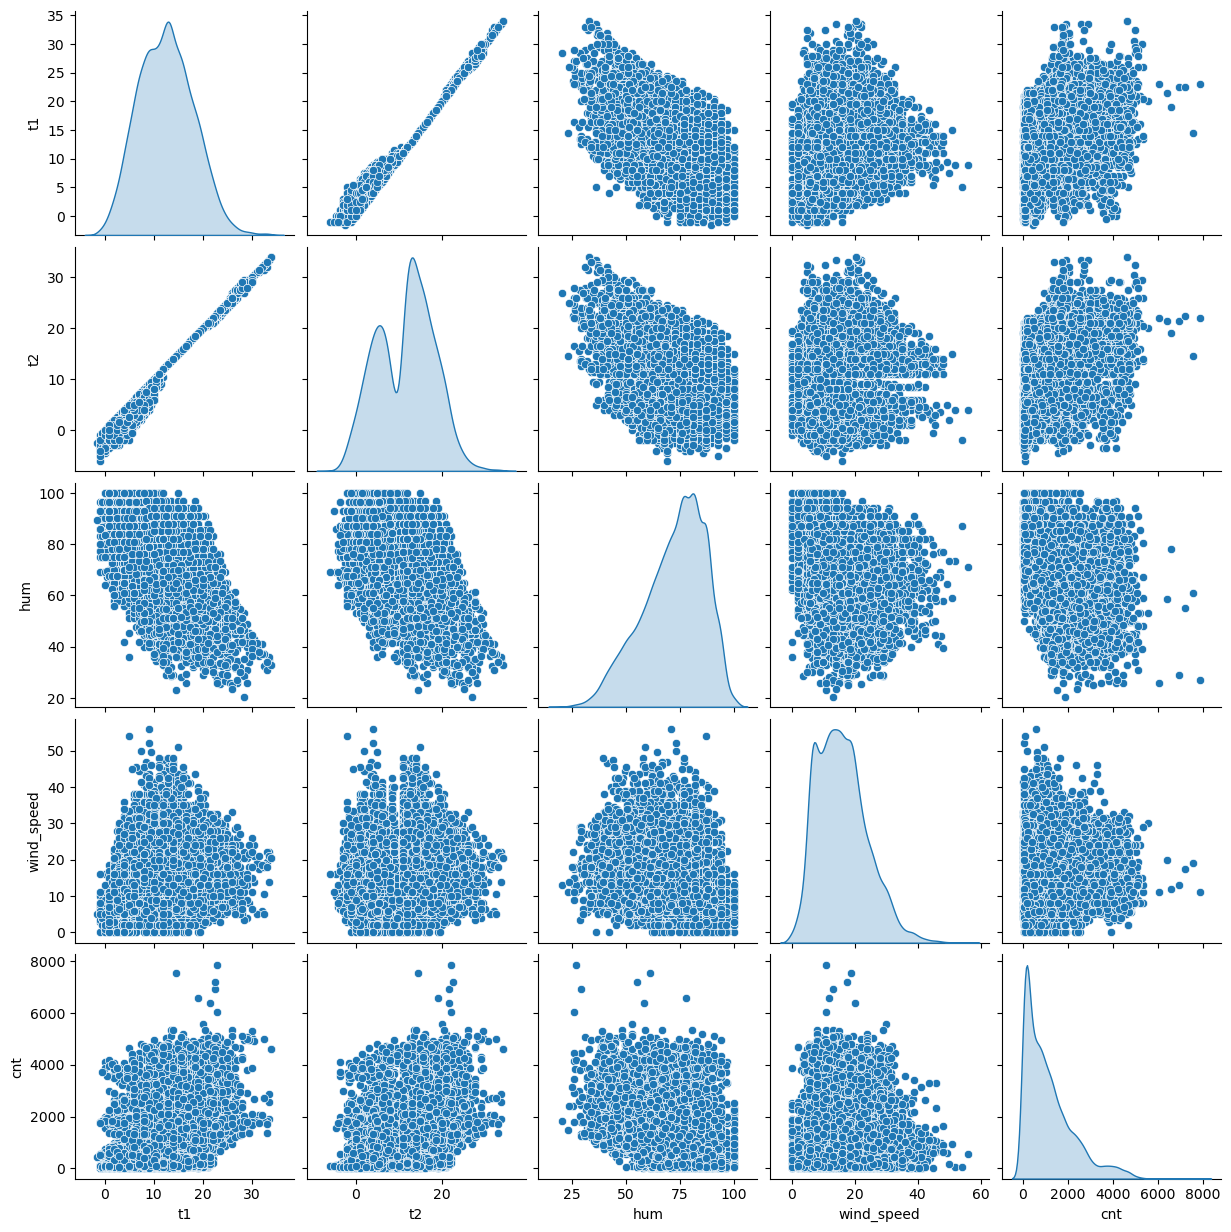

In [13]:
bike_num=df_train[[ 't1', 't2', 'hum', 'wind_speed','cnt']]

sns.pairplot(bike_num, diag_kind='kde')
plt.savefig('numeric.png')
plt.show()


In [14]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17342 entries, 0 to 17341
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   cnt           17342 non-null  int64   
 1   t1            17342 non-null  float64 
 2   t2            17342 non-null  float64 
 3   hum           17342 non-null  float64 
 4   wind_speed    17342 non-null  float64 
 5   weather_code  17342 non-null  category
 6   is_holiday    17342 non-null  float64 
 7   is_weekend    17342 non-null  float64 
 8   season        17342 non-null  category
 9   year          17342 non-null  category
 10  month         17342 non-null  category
 11  weekday       17342 non-null  category
 12  time_period   17342 non-null  category
dtypes: category(6), float64(6), int64(1)
memory usage: 1.2 MB


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ver

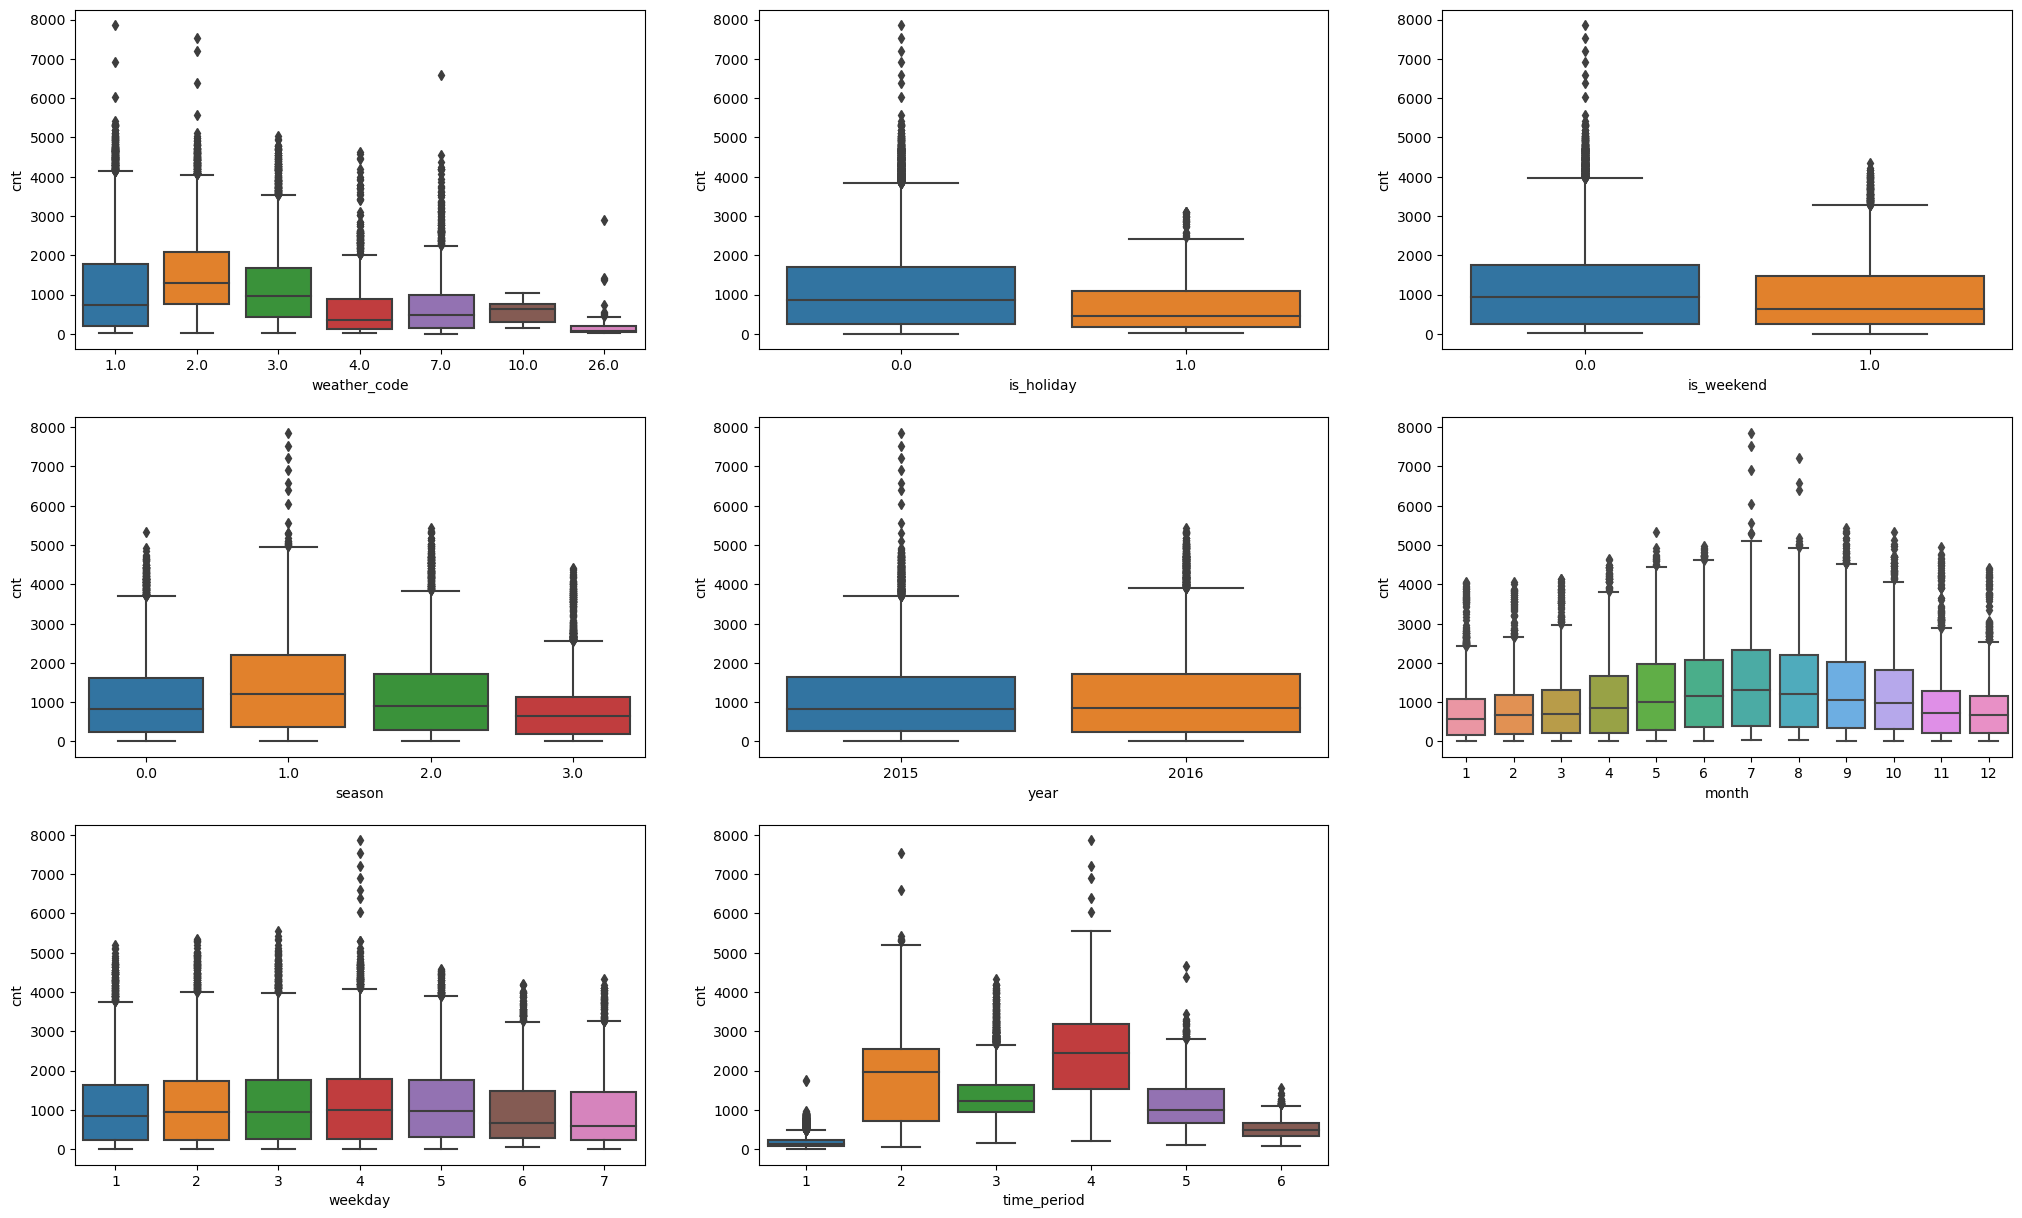

In [15]:
plt.figure(figsize=(25, 15))
plt.subplot(3,3,1)
sns.boxplot(x = 'weather_code', y = 'cnt', data = bike)
plt.subplot(3,3,2)
sns.boxplot(x = 'is_holiday', y = 'cnt', data = bike)
plt.subplot(3,3,3)
sns.boxplot(x = 'is_weekend', y = 'cnt', data = bike)
plt.subplot(3,3,4)
sns.boxplot(x = 'season', y = 'cnt', data = bike)
plt.subplot(3,3,5)
sns.boxplot(x = 'year', y = 'cnt', data = bike)
plt.subplot(3,3,6)
sns.boxplot(x = 'month', y = 'cnt', data = bike)
plt.subplot(3,3,7)
sns.boxplot(x = 'weekday', y = 'cnt', data = bike)
plt.subplot(3,3,8)
sns.boxplot(x = 'time_period', y = 'cnt', data = bike)
plt.savefig('categorical.png')
plt.show()


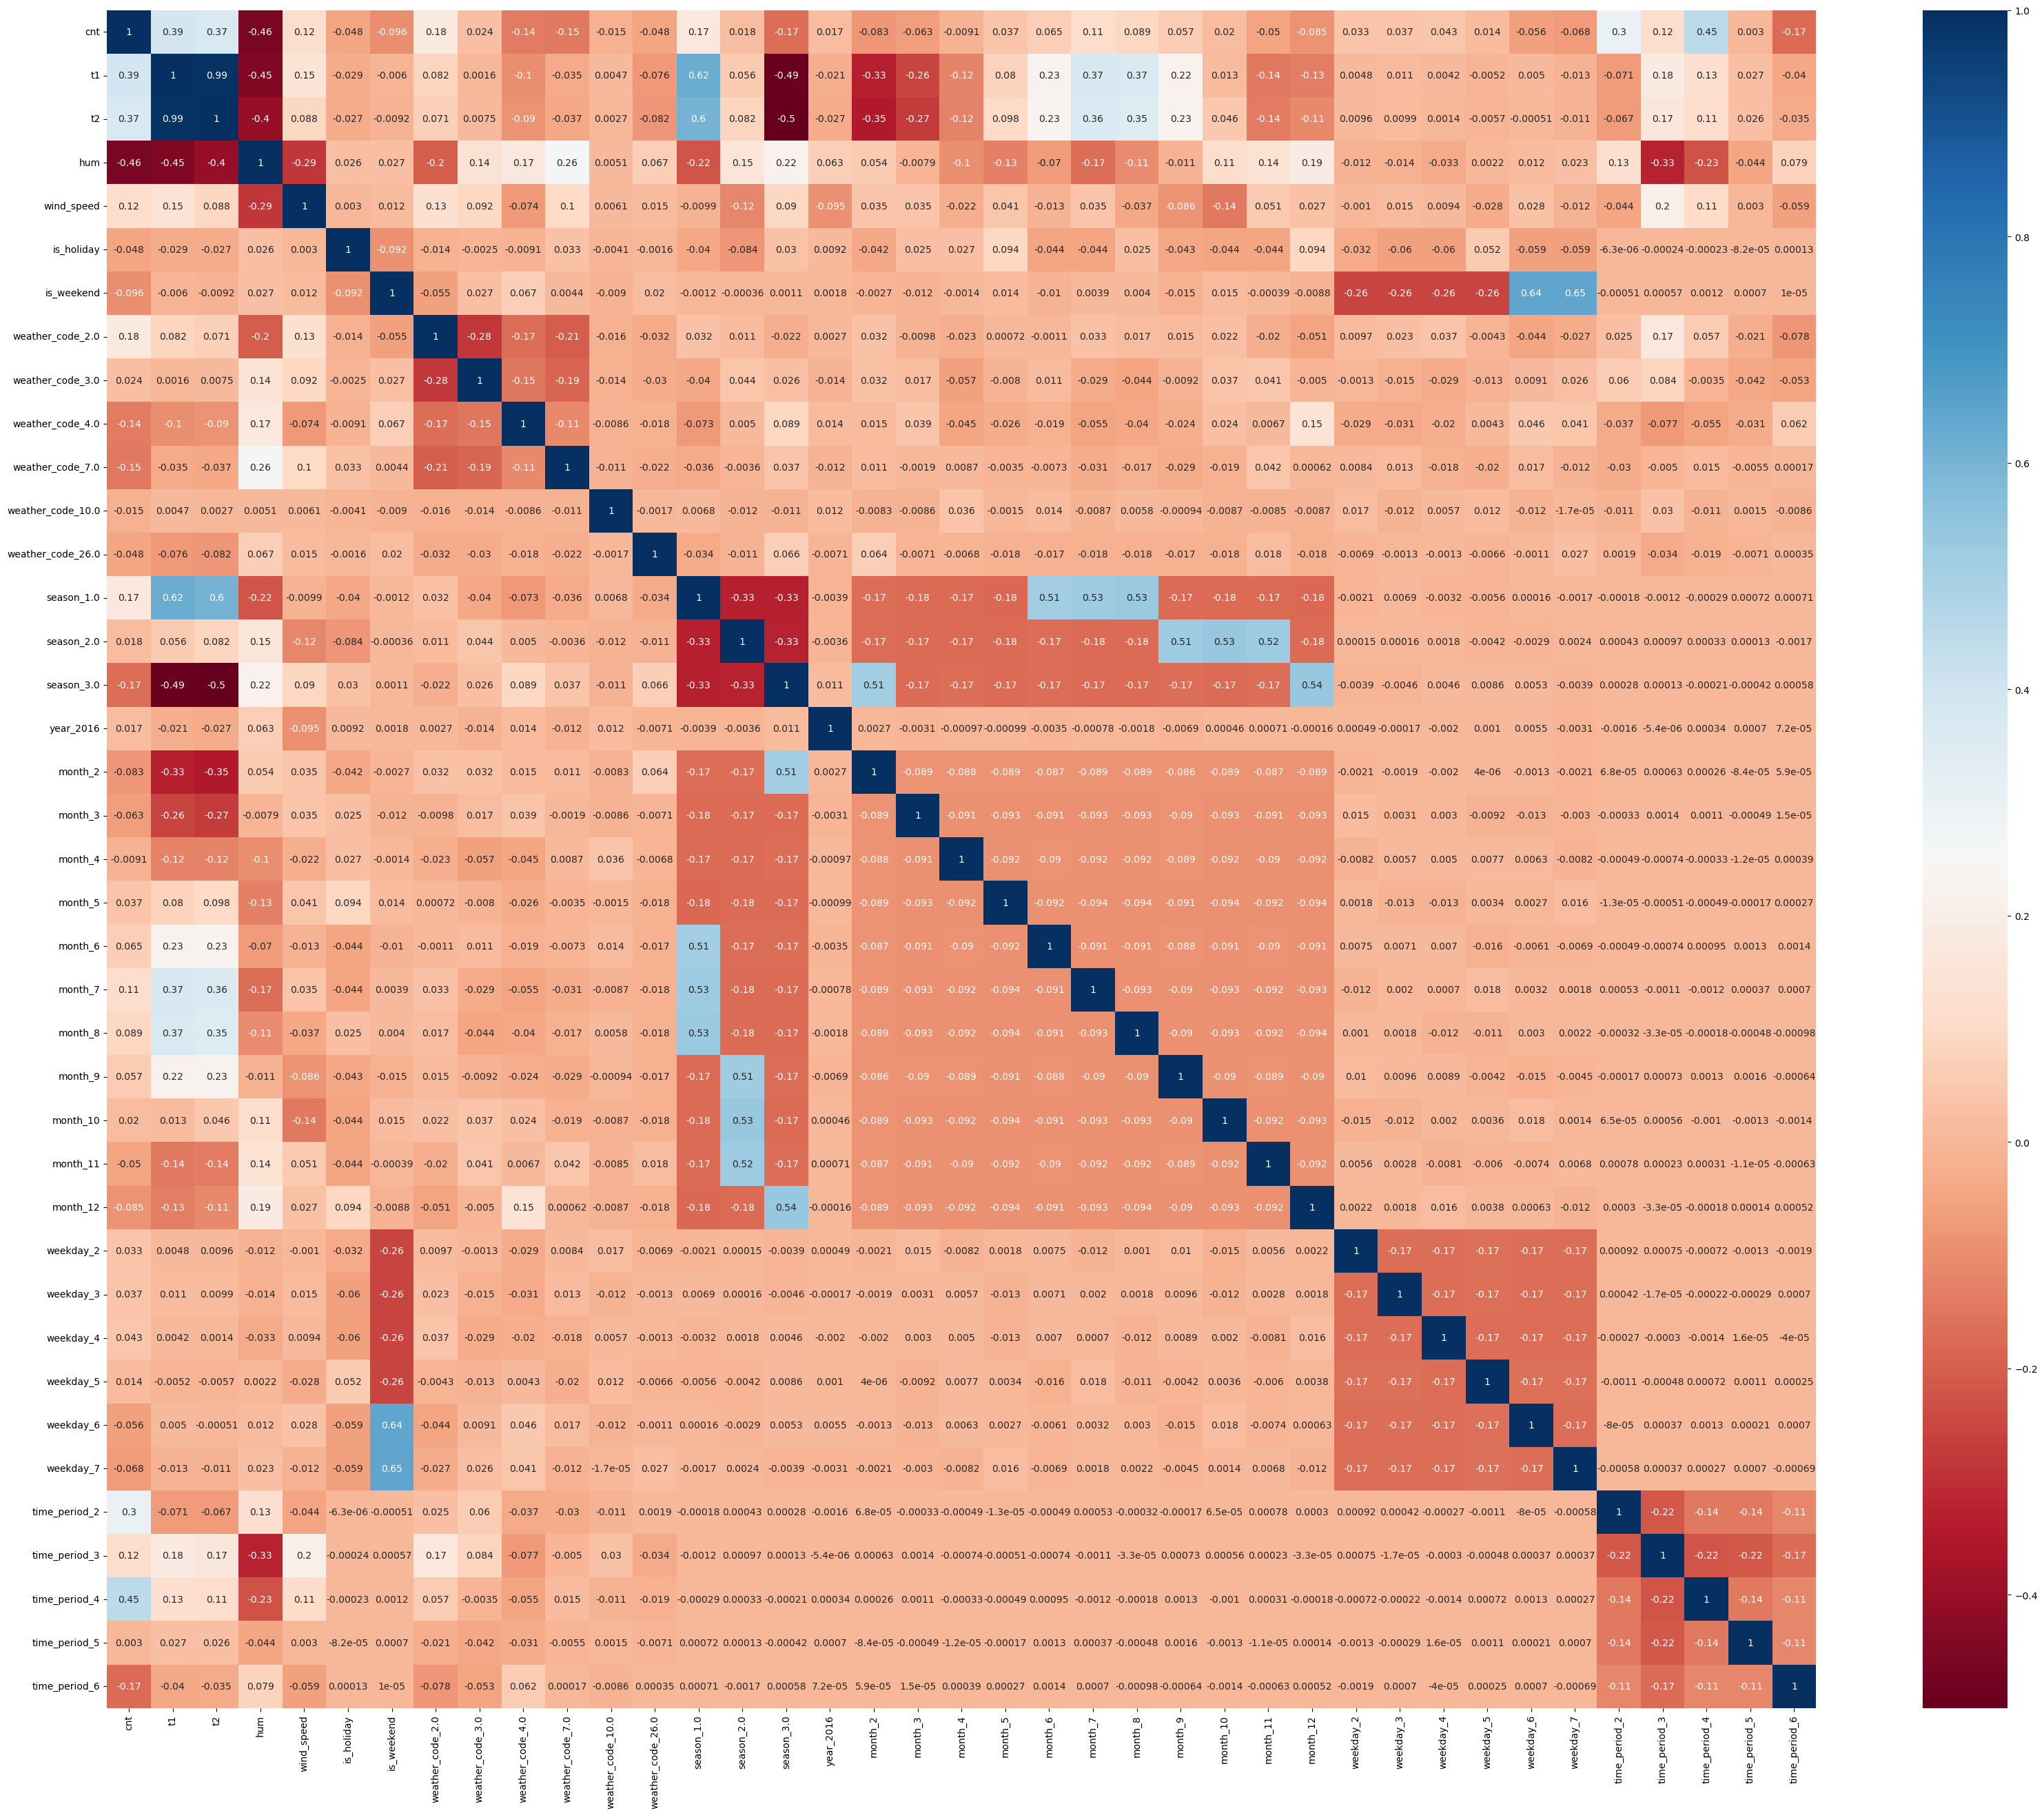

In [16]:
plt.figure(figsize = (40,32))
sns.heatmap(bike_new.corr(), annot = True, cmap="RdBu")
plt.savefig('corr.png')
plt.show()


In [17]:
scaler = MinMaxScaler()
num_vars = ['t1', 't2', 'hum', 'wind_speed','cnt']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.describe()

,cnt,t1,t2,hum,wind_speed,is_holiday,is_weekend
count,12139.000000,12139.000000,12139.000000,12139.000000,12139.000000,12139.000000,12139.000000
mean,0.144469,0.394311,0.438984,0.650922,0.285277,0.021583,0.287009
std,0.136657,0.156178,0.164490,0.179118,0.141761,0.145325,0.452384
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.033588,0.281690,0.300000,0.534591,0.178571,0.000000,0.000000
50%,0.106997,0.394366,0.462500,0.679245,0.267857,0.000000,0.000000
75%,0.210051,0.492958,0.550000,0.786164,0.375000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
y_train = df_train.pop('cnt')
X_train = df_train

In [19]:
lm = LinearRegression()

rfecv = RFECV(estimator=lm)
rfecv = rfecv.fit(X_train, y_train)

list(zip(X_train.columns, rfecv.support_, rfecv.ranking_))

[('t1', True, 1),
 ('t2', True, 1),
 ('hum', True, 1),
 ('wind_speed', True, 1),
 ('is_holiday', True, 1),
 ('is_weekend', True, 1),
 ('weather_code_2.0', False, 10),
 ('weather_code_3.0', False, 12),
 ('weather_code_4.0', False, 3),
 ('weather_code_7.0', True, 1),
 ('weather_code_10.0', True, 1),
 ('weather_code_26.0', False, 5),
 ('season_1.0', True, 1),
 ('season_2.0', True, 1),
 ('season_3.0', True, 1),
 ('year_2016', False, 2),
 ('month_2', False, 4),
 ('month_3', True, 1),
 ('month_4', True, 1),
 ('month_5', True, 1),
 ('month_6', True, 1),
 ('month_7', True, 1),
 ('month_8', True, 1),
 ('month_9', True, 1),
 ('month_10', True, 1),
 ('month_11', True, 1),
 ('month_12', False, 11),
 ('weekday_2', False, 7),
 ('weekday_3', False, 6),
 ('weekday_4', False, 8),
 ('weekday_5', False, 9),
 ('weekday_6', True, 1),
 ('weekday_7', True, 1),
 ('time_period_2', True, 1),
 ('time_period_3', True, 1),
 ('time_period_4', True, 1),
 ('time_period_5', True, 1),
 ('time_period_6', True, 1)]

In [20]:
col = X_train.columns[rfecv.support_]
X_train_rfe = X_train[col]
X_train_rfe = X_train_rfe.astype(float)

In [21]:
def get_vif(X_train_rfe):
    vif = pd.DataFrame()
    vif['Features'] = X_train_rfe.columns
    vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    display(vif)

get_vif(X_train_rfe)

/opt/conda/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Features,VIF
14,month_6,inf
21,weekday_7,inf
20,weekday_6,inf
19,month_11,inf
5,is_weekend,inf
18,month_10,inf
17,month_9,inf
8,season_1.0,inf
9,season_2.0,inf
16,month_8,inf


In [22]:
def run_reg(X_train_rfe,y_train):
    X_train_lm = sm.add_constant(X_train_rfe)
    lr = sm.OLS(y_train, X_train_lm).fit()
    print(lr.summary())
    return lr
run_reg(X_train_rfe,y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     910.2
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:13:40   Log-Likelihood:                 13027.
No. Observations:               12139   AIC:                        -2.601e+04
Df Residuals:                   12115   BIC:                        -2.583e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0843      0.00

In [23]:
X_train_new=X_train_rfe.copy()

X_train_new = X_train_new.drop(["month_9"], axis = 1)
get_vif(X_train_new)
run_reg(X_train_new,y_train)

/opt/conda/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Features,VIF
20,weekday_7,inf
19,weekday_6,inf
16,month_8,inf
5,is_weekend,inf
15,month_7,inf
14,month_6,inf
8,season_1.0,inf
0,t1,62.49
1,t2,56.70
9,season_2.0,23.75


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     910.2
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:13:41   Log-Likelihood:                 13027.
No. Observations:               12139   AIC:                        -2.601e+04
Df Residuals:                   12115   BIC:                        -2.583e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0843      0.00

In [24]:
X_train_new = X_train_new.drop(["month_8"], axis = 1)
get_vif(X_train_new)
run_reg(X_train_new,y_train)

/opt/conda/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Features,VIF
19,weekday_7,inf
18,weekday_6,inf
5,is_weekend,inf
0,t1,62.49
1,t2,56.70
8,season_1.0,25.62
9,season_2.0,23.75
10,season_3.0,16.17
13,month_5,6.85
11,month_3,5.66


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     910.2
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:13:41   Log-Likelihood:                 13027.
No. Observations:               12139   AIC:                        -2.601e+04
Df Residuals:                   12115   BIC:                        -2.583e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0845      0.00

In [25]:
X_train_new = X_train_new.drop(["is_weekend"], axis = 1)
get_vif(X_train_new)
run_reg(X_train_new,y_train)

,Features,VIF
0,t1,62.49
1,t2,56.70
7,season_1.0,25.62
8,season_2.0,23.75
9,season_3.0,16.17
12,month_5,6.85
10,month_3,5.66
11,month_4,5.55
16,month_11,2.35
2,hum,2.05


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     910.2
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:13:42   Log-Likelihood:                 13027.
No. Observations:               12139   AIC:                        -2.601e+04
Df Residuals:                   12115   BIC:                        -2.583e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0845      0.00

In [26]:
X_train_new = X_train_new.drop(["t2"], axis = 1)
get_vif(X_train_new)
run_reg(X_train_new,y_train)

,Features,VIF
6,season_1.0,25.62
7,season_2.0,23.73
8,season_3.0,16.16
11,month_5,6.78
9,month_3,5.66
10,month_4,5.53
0,t1,3.74
15,month_11,2.35
14,month_10,2.00
19,time_period_3,1.97


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     948.5
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:13:43   Log-Likelihood:                 13014.
No. Observations:               12139   AIC:                        -2.598e+04
Df Residuals:                   12116   BIC:                        -2.581e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0834      0.00

In [27]:
X_train_new = X_train_new.drop(["season_1.0"], axis = 1)
get_vif(X_train_new)
run_reg(X_train_new,y_train)

,Features,VIF
1,hum,14.66
0,t1,13.01
2,wind_speed,6.28
6,season_2.0,5.58
7,season_3.0,5.04
18,time_period_3,2.58
14,month_11,2.44
8,month_3,2.17
13,month_10,2.15
12,month_7,1.84


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     948.5
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:13:43   Log-Likelihood:                 13014.
No. Observations:               12139   AIC:                        -2.598e+04
Df Residuals:                   12116   BIC:                        -2.581e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0968      0.00

In [28]:
X_train_new = X_train_new.drop(["hum"], axis = 1)
get_vif(X_train_new)
run_reg(X_train_new,y_train)

,Features,VIF
0,t1,8.48
1,wind_speed,6.16
5,season_2.0,4.80
13,month_11,2.27
17,time_period_3,2.20
6,season_3.0,2.13
12,month_10,2.09
11,month_7,1.77
18,time_period_4,1.59
10,month_6,1.58


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     921.7
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:13:43   Log-Likelihood:                 12729.
No. Observations:               12139   AIC:                        -2.541e+04
Df Residuals:                   12117   BIC:                        -2.525e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0292      0.00

In [29]:
X_train_new = X_train_new.drop(["wind_speed"], axis = 1)
get_vif(X_train_new)
run_reg(X_train_new,y_train)

,Features,VIF
0,t1,6.69
4,season_2.0,4.80
12,month_11,2.17
16,time_period_3,2.16
11,month_10,2.08
10,month_7,1.76
5,season_3.0,1.71
17,time_period_4,1.58
9,month_6,1.57
18,time_period_5,1.49


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     965.0
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:13:44   Log-Likelihood:                 12718.
No. Observations:               12139   AIC:                        -2.539e+04
Df Residuals:                   12118   BIC:                        -2.524e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0295      0.00

In [30]:
X_train_new = X_train_new.drop(["season_2.0"], axis = 1)
get_vif(X_train_new)
run_reg(X_train_new,y_train)

,Features,VIF
0,t1,5.07
15,time_period_3,2.16
16,time_period_4,1.58
4,season_3.0,1.54
17,time_period_5,1.49
9,month_7,1.49
14,time_period_2,1.43
8,month_6,1.37
7,month_5,1.31
18,time_period_6,1.30


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     1016.
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:13:44   Log-Likelihood:                 12718.
No. Observations:               12139   AIC:                        -2.540e+04
Df Residuals:                   12119   BIC:                        -2.525e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0313      0.00

In [31]:
X_train_new = X_train_new.drop(["month_3"], axis = 1)
get_vif(X_train_new)
run_reg(X_train_new,y_train)

,Features,VIF
0,t1,5.05
14,time_period_3,2.09
15,time_period_4,1.54
16,time_period_5,1.46
4,season_3.0,1.46
8,month_7,1.45
13,time_period_2,1.39
7,month_6,1.33
6,month_5,1.28
17,time_period_6,1.27


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     1072.
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:13:45   Log-Likelihood:                 12718.
No. Observations:               12139   AIC:                        -2.540e+04
Df Residuals:                   12120   BIC:                        -2.526e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0296      0.00

In [32]:
X_train_new = X_train_new.drop(["month_6"], axis = 1)
get_vif(X_train_new)
run_reg(X_train_new,y_train)

,Features,VIF
0,t1,4.33
13,time_period_3,2.08
14,time_period_4,1.54
15,time_period_5,1.46
4,season_3.0,1.40
12,time_period_2,1.39
7,month_7,1.34
16,time_period_6,1.27
6,month_5,1.22
10,weekday_6,1.20


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     1135.
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:13:45   Log-Likelihood:                 12718.
No. Observations:               12139   AIC:                        -2.540e+04
Df Residuals:                   12121   BIC:                        -2.527e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0294      0.00

In [33]:
X_train_new = X_train_new.drop(["month_10"], axis = 1)
get_vif(X_train_new)
lr=run_reg(X_train_new,y_train)

,Features,VIF
0,t1,4.17
12,time_period_3,2.08
13,time_period_4,1.54
14,time_period_5,1.45
11,time_period_2,1.39
4,season_3.0,1.36
7,month_7,1.30
15,time_period_6,1.27
6,month_5,1.19
9,weekday_6,1.19


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     1206.
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:13:45   Log-Likelihood:                 12718.
No. Observations:               12139   AIC:                        -2.540e+04
Df Residuals:                   12122   BIC:                        -2.528e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0288      0.00

/tmp/ipykernel_35062/2592172417.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((res), bins = 20)
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


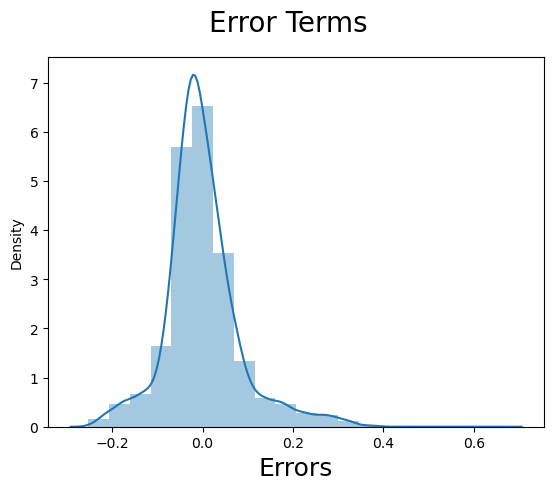

In [34]:
X_train_lm = sm.add_constant(X_train_new)
y_train_pred = lr.predict(X_train_lm)

res = y_train-y_train_pred
fig = plt.figure()
sns.distplot((res), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)
plt.xlabel('Errors', fontsize = 18)
plt.savefig('error.png')

In [35]:
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

y_test = df_test.pop('cnt')
X_test = df_test

finalCol=X_train_new.columns
X_test=X_test[finalCol]

X_test_lm = sm.add_constant(X_test)
y_pred = lr.predict(X_test_lm)

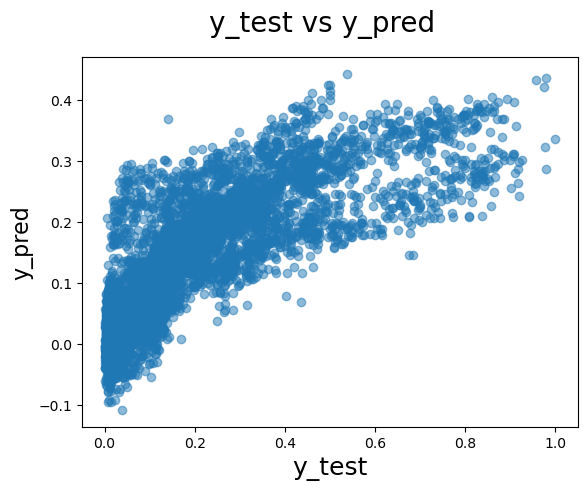

In [36]:
fig = plt.figure()
plt.scatter(y_test, y_pred, alpha=.5)
fig.suptitle('y_test vs y_pred', fontsize = 20)
plt.xlabel('y_test', fontsize = 18)
plt.ylabel('y_pred', fontsize = 16)
plt.savefig('test_pred.png')
plt.show()

/tmp/ipykernel_35062/1351748532.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_coefficients = coefficients[sorted_indices]


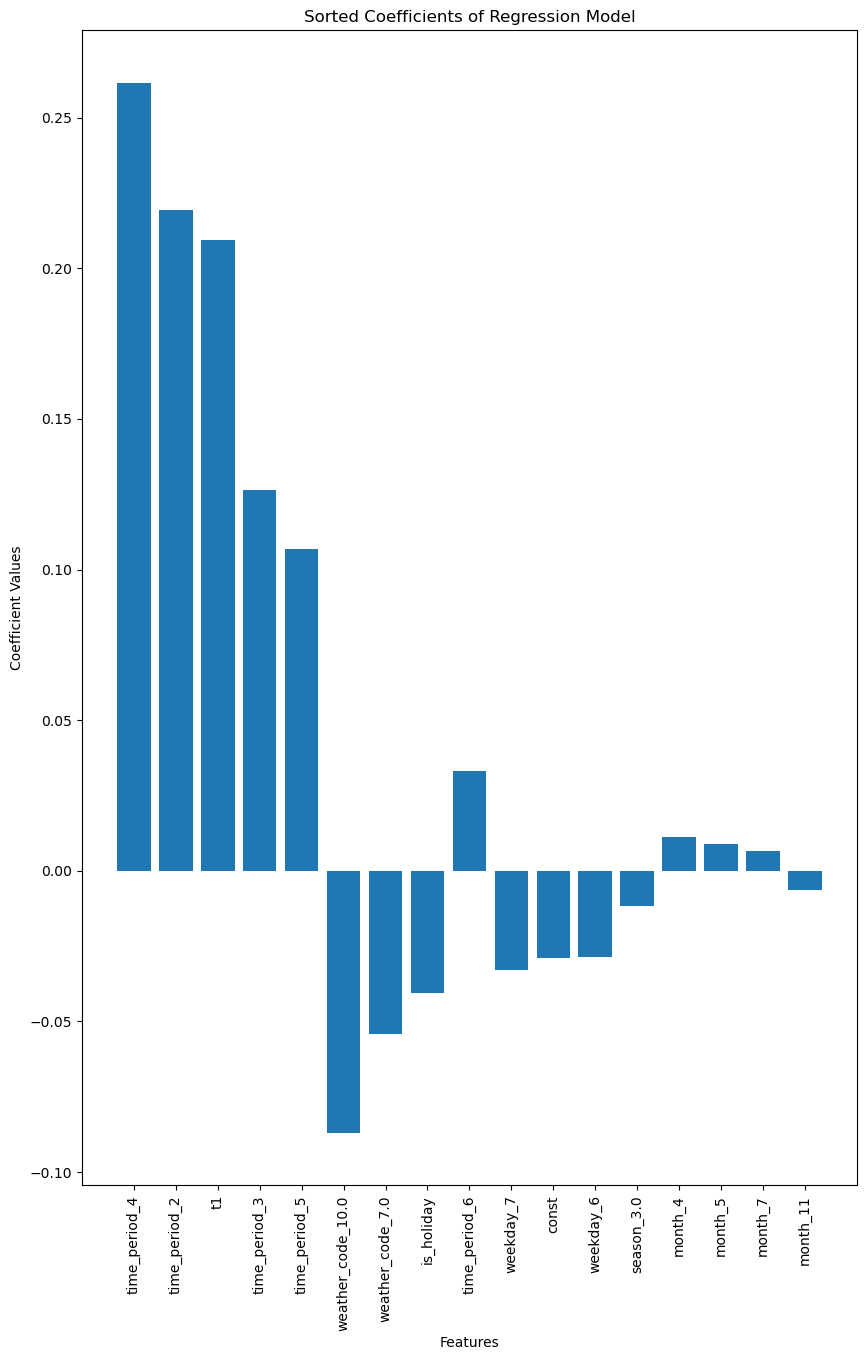

In [39]:
coefficients=lr.params
sorted_indices = np.argsort(np.abs(coefficients))[::-1]

sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = X_test_lm.columns[sorted_indices]

plt.figure(figsize=(10, 15))
plt.bar(range(len(coefficients)), sorted_coefficients)
plt.xticks(range(len(coefficients)), sorted_feature_names, rotation='vertical')
plt.title('Sorted Coefficients of Regression Model')
plt.xlabel('Features')
plt.ylabel('Coefficient Values')
plt.savefig('result.png')
plt.show()
